In [1]:
%matplotlib inline
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
from pyluos import Robot
import time


In [2]:
##### ROLL&PITCH&YAW #####
def RPY(locus_of_desired_pose):

    ## Find the Plane Normal and hence the RF of the triangle
    #init
    vectorCircle_P4 = locus_of_desired_pose
    norme = LA.norm(vectorCircle_P4)
    for PoseNumber in range(3):
        #normalization
        vectorCircle_P4[PoseNumber] = vectorCircle_P4[PoseNumber]/norme

        
    imin = 1 ##bias of y axis to be as close as possible to the Y axis of the inertial frame: 
    #needed to keep the yaw angle as small as possible. High yaw values yields
    #high joints variations from the rest pose!

    Yvector = np.zeros(3)
    dt    = vectorCircle_P4[imin]

    Yvector[imin] = 1
    for i in range(3):
        Yvector[i] = Yvector[i] -  dt*vectorCircle_P4[i]


    Yvector = Yvector/LA.norm(Yvector)

        
        
    newX = np.cross(Yvector,vectorCircle_P4,axis=0)
    newY = Yvector
    newZ = vectorCircle_P4
    
    R0fixedtoP4 = np.array([newX,newY,newZ]) #New frame
    R0fixedtoP4.reshape(3,3)
        

    x0 = np.array([1,0,0])
    y0 = np.array([0,1,0])
    z0 = np.array([0,0,1])
    R0 = np.array([x0,y0,z0])
    R0.reshape(3,3)

    
    rot = np.dot(LA.inv(R0),R0fixedtoP4) #Rotation matrix
    
    rotation = R.from_dcm(rot)
    
    RPY = rotation.as_euler('xyz',degrees=True) #Euler angles = roll, pitch, yaw

    
    return RPY

In [3]:
def get_angles(Roll,Pitch,Yaw):
    
    roll = np.deg2rad(Roll)
    pitch = np.deg2rad(Pitch)
    yaw = np.deg2rad(Yaw)

    ##Fixed Point in Space

    P4 = [0,0,83.40]

    #Equations Parameters definition
    #L 120-Angled: Alto Basso Medio creano una 
    #circonferenza con centro in Z=19.06 e raggio R nel piano XY w.r.t. RF0fixed

    #L ALTO (Medio e Basso formano lo stesso cerchio )
    l1a = 19.33
    l2a = 22.01;
    psi = np.deg2rad(120)
    #Raggio cerchio generato da L-120angled nel piano XY
    #centro del medesimo cerchio
    centroXY = [0,0,64.64]
    #il raggio e' uguale per tutte e tre le Ldue
    Rl2 = 37.528

    ##IK parameters

    A = centroXY[2] - P4[2]
    B = Rl2*math.sin(pitch)
    C = Rl2*math.cos(pitch)*math.cos(roll)

    E = Rl2*(math.cos(yaw)*math.sin(roll) - math.cos(roll)*math.sin(pitch)*math.sin(yaw))
    F = Rl2*math.cos(pitch)*math.sin(yaw)

    H = Rl2*(math.sin(roll)*math.sin(yaw) + math.cos(roll)*math.cos(yaw)*math.sin(pitch))
    I = Rl2*math.cos(pitch)*math.cos(yaw)
    L = Rl2*(math.sin(pitch)/2 - (math.sqrt(3)*math.cos(pitch)*math.sin(roll))/2)

    M = Rl2*((math.cos(pitch)*math.sin(yaw))/2 + (math.sqrt(3)*(math.cos(roll)*math.cos(yaw) + math.sin(pitch)*math.sin(roll)*math.sin(yaw)))/2)
    N = Rl2*((math.cos(pitch)*math.cos(yaw))/2 - (math.sqrt(3)*(math.cos(roll)*math.sin(yaw) - math.cos(yaw)*math.sin(pitch)*math.sin(roll)))/2)
    O = Rl2*(math.sin(pitch)/2 + (math.sqrt(3)*math.cos(pitch)*math.sin(roll))/2)
    P = Rl2*((math.cos(pitch)*math.sin(yaw))/2 - (math.sqrt(3)*(math.cos(roll)*math.cos(yaw) + math.sin(pitch)*math.sin(roll)*math.sin(yaw)))/2)
    R = Rl2*((math.cos(pitch)*math.cos(yaw))/2 + (math.sqrt(3)*(math.cos(roll)*math.sin(yaw) - math.cos(yaw)*math.sin(pitch)*math.sin(roll)))/2)

    ##Solutions to IK:
    ##ALTO solve t3 -> 2 solutions:
    #eq3alto = A - C*cos(t3) + B*sin(t3)
    #sols: 1) -2*atan2(B + (- A^2 + B^2 + C^2)^(1/2), A + C)
    #      2) -2*atan2(B - (- A^2 + B^2 + C^2)^(1/2), A + C)

    #eps_zero = 1e-4;

    temp = (-A)**2 + B**2 + C**2
    #testa temp se negativo:
    if temp<0.0:
        ##disp('Non real solutions');
        return None

    i=0

    yplus = (B + math.sqrt((-A)**2 + B**2 + C**2))
    yminus = (B - math.sqrt((-A)**2 + B**2 + C**2))
    x = A + C

    St3alto=[0,0]

    if (yplus != 0) and (x != 0):
        St3alto[0] = -2*math.atan2(yplus,x)
        i=i+1
    if (yminus != 0) and (x != 0):
        St3alto[1] = -2*math.atan2(yminus,x)
        i=i+1

    #% Solve for t1 alto: eq 1 and 2:
    #%eq2alto = E*cos(t3) + D*sin(t1) - F*sin(t3) 
    #%eq1alto = D*cos(t1) - H*cos(t3) - I*sin(t3)
    #%Combination to avoid asin and acos but using atan2

    #%           -E*cos(t3) + F*sin(t3)
    #% tan(t1) = ----------------------
    #%           H*cos(t3) + I*sin(t3)

    y1 = -E*math.cos(St3alto[0]) + F*math.sin(St3alto[0])
    x1 = H*math.cos(St3alto[0]) + I*math.sin(St3alto[0])

    y2 = -E*math.cos(St3alto[1]) + F*math.sin(St3alto[1])
    x2 = H*math.cos(St3alto[1]) + I*math.sin(St3alto[1])

    if i==2:
        ##disp('found 2 solutions for t3 alto')
        ##disp('solve for t1 alto...')
        #disp('trying first solution:')
        found_solutions = 0

        if ( y1 !=0) or ( x1 != 0):
            #solve for t1
            #sol 1
            St1alto_1 = math.atan2(y1,x1)

            found_solutions = 1

        #disp('trying second solution:')
        if ( y2 !=0) or ( x2 != 0):
            #solve for t1
            #sol 2
            St1alto_2 = math.atan2(y2,x2) 
            found_solutions = 1

        if(found_solutions == 0):
            #disp('t1 alto cannot be found...No IK Available for given poses...quit()')
            return None



    elif(i==1):
        #disp('found only 1 solution for t3 alto')
        #disp('solve for t1 alto...')
        if (y1 !=0) or (x1 != 0): 
            St1alto_1 = math.atan2(y1,x1)
        else:
            #disp('atan2(0,0) Undefined...NO IK Available...Quit() !!! ');
            return None

    elif(i==0):
        #disp('found No solutions for t3 alto...quit!!')
        return None
    else:
        #disp('Error t3 alto');
        return None

    ## MEDIO solve t3 -> 2 solutions:
     #eq3medio = A - C*cos(t3) - L*sin(t3)
        #sols: 1) 2*atan2(L + (- A^2 + C^2 + L^2)^(1/2), A + C)
        #      2) 2*atan2(L - (- A^2 + C^2 + L^2)^(1/2), A + C)

    temp = (-A)**2 + C**2 + L**2
    #testa temp se negativo:
    if temp<0.0:
        #disp('Non real solutions');
        return None

    i=0

    yplus = (L + math.sqrt((-A)**2 + L**2 + C**2))
    yminus = (L - math.sqrt((-A)**2 + L**2 + C**2))
    x = A + C

    St3medio=[0,0]

    if ( yplus != 0) and (x != 0):
        St3medio[i] = 2*math.atan2(yplus,x)
        i=i+1
    if (yminus != 0) and (x != 0):
        St3medio[i] = 2*math.atan2(yminus,x)
        i=i+1


    # Solve for t1 medio: eq 1 and 2:
    #eq2medio = E*cos(t3) + D*sin(t1) + M*sin(t3)
    #eq1medio = D*cos(t1) - H*cos(t3) + N*sin(t3)
    #Combination to avoid asin and acos but using atan2

    #           -E*cos(t3) - M*sin(t3)
    # tan(t1) = ----------------------
    #           H*cos(t3) - N*sin(t3)


    y1 = -E*math.cos(St3medio[0]) - M*math.sin(St3medio[0])
    x1 = H*math.cos(St3medio[0]) - N*math.sin(St3medio[0])

    y2 = -E*math.cos(St3medio[1]) - M*math.sin(St3medio[1])
    x2 = H*math.cos(St3medio[1]) - N*math.sin(St3medio[1])

    if(i==2):
        #disp('found 2 solutions for t3 medio')
        #disp('solve for t1 medio...')
        #disp('trying first solution:')
        found_solutions = 0



        if ( y1 !=0) or ( x1 != 0):
            #solve for t1
            #sol 1
            St1medio_1 = math.atan2(y1,x1)      
            found_solutions = 1


        #disp('trying second solution:')
        if ( y2 !=0) or ( x2 != 0):
            #solve for t1
            #sol 2
            St1medio_2 = math.atan2(y2,x2)
            found_solutions = 1

        if(found_solutions == 0):
            #disp('t1 medio cannot be found...No IK Available for given poses...quit()')
            return None



    elif(i==1):
        #disp('found only 1 solution for t3 medio')
        #disp('solve for t1 medio...')
        if ( y1 !=0 ) or ( x1 != 0): 
            St1medio_1 = math.atan2(y1,x1)
        else:
            #disp('atan2(0,0) Undefined...NO IK Available...Quit() !!! ');
            return None

    elif(i==0):
        #disp('found No solutions for t3 medio...quit!!')
        return None
    else:
        #disp('Error t3 medio');
        return None

    ## BASSO solve t3 -> 2 solutions:
     #eq3basso = A - C*cos(t3) - O*sin(t3)
        #sols: 1) 2*atan2(O + (- A^2 + C^2 + O^2)^(1/2), A + C)
        #      2) 2*atan2(O - (- A^2 + C^2 + O^2)^(1/2), A + C)

    temp = (-A)**2 + C**2 + O**2
    #testa temp se negativo:
    if temp<0.0:
        #disp('Non real solutions');
        return None

    i=0

    yplus = (O + math.sqrt((-A)**2 + C**2 + O**2))
    yminus = (O - math.sqrt( (-A)**2 + C**2 + O**2))
    x = A + C

    St3basso=[0,0]

    if ( yplus != 0) and (x != 0):
        St3basso[i] = 2*math.atan2(yplus,x)
        i=i+1
    if (yminus != 0) and (x != 0):
        St3basso[i] = 2*math.atan2(yminus,x)
        i=i+1

    # Solve for t1 basso: eq 1 and 2:
    #eq2basso = E*cos(t3) + D*sin(t1) + P*sin(t3)
    #eq1basso = D*cos(t1) - H*cos(t3) + R*sin(t3)
    #Combination to avoid asin and acos but using atan2

    #           -E*cos(t3) - P*sin(t3)
    # tan(t1) = ----------------------
    #           H*cos(t3) - R*sin(t3)


    y1 = -E*math.cos(St3basso[0]) - P*math.sin(St3basso[0])
    x1 = H*math.cos(St3basso[0]) - R*math.sin(St3basso[0])

    y2 = -E*math.cos(St3basso[1]) - P*math.sin(St3basso[1])
    x2 = H*math.cos(St3basso[1]) - R*math.sin(St3basso[1])

    if(i==2):
        #disp('found 2 solutions for t3 basso')
        #disp('solve for t1 basso...')
        #disp('trying first solution:')
        found_solutions = 0

        if ( y1 !=0) or ( x1 != 0):
            #solve for t1
            #sol 1
            St1basso_1 = math.atan2(y1,x1)

            found_solutions = 1

        #disp('trying second solution:')
        if ( y2 !=0) or ( x2 != 0):
            #solve for t1
            #sol 2
            St1basso_2 = math.atan2(y2,x2)
            found_solutions = 1

        if(found_solutions == 0):
            #disp('t1 basso cannot be found...No IK Available for given poses...quit()')
            return None



    elif(i==1):
        #disp('found only 1 solution for t3 basso')
        #disp('solve for t1 basso...')
        if ( y1 !=0 ) or ( x1 != 0): 
            St1basso_1 = math.atan2(y1,x1)
        else:
            #disp('atan2(0,0) Undefined...NO IK Available...Quit() !!! ');
            return None

    elif(i==0):
        #disp('found No solutions for t3 basso...quit!!')
        return None
    else:
        #disp('Error t3 basso');
        return None


    ## find the closest solution to home pose
        #disp('Solutions: q1 ALTO:' )
    if abs(St1alto_1-0) < abs(St1alto_2-0):
        q1alto = np.rad2deg(St1alto_1)
    else:
        q1alto = np.rad2deg(St1alto_2)

    #disp('Solutions: q1 MEDIO:' )
    if abs(St1medio_1-(-(2.0/3)*math.pi)) < abs(St1medio_2-(-(2.0/3)*math.pi)):
        q1medio = np.rad2deg(St1medio_1)
    else:
        q1medio = np.rad2deg(St1medio_2)

    #disp('Solutions: q1 BASSO:' )
    if abs(St1basso_1-((2.0/3)*math.pi)) < abs(St1basso_2-((2.0/3)*math.pi)):
        q1basso = np.rad2deg(St1basso_1)
    else:
        q1basso = np.rad2deg(St1basso_2)

    return [q1alto,q1basso,q1medio] ##Les middle et bottom sont inversés

In [4]:
r = Robot('/dev/cu.usbserial-DN03V2HP')


###########Setup############

r.disk_bottom.encoder_res = 5
r.disk_middle.encoder_res = 5
r.disk_top.encoder_res = 5


r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()


r.disk_bottom.reduction = 232
r.disk_middle.reduction = 232
r.disk_top.reduction = 232


r.disk_bottom.wheel_size = 60.0
r.disk_middle.wheel_size = 60.0
r.disk_top.wheel_size = 60


r.disk_bottom.positionPid = [9,0.02,100]
r.disk_middle.positionPid = [9,0.02,100]
r.disk_top.positionPid = [9,0.02,100]


r.disk_bottom.rot_position_mode(True)
r.disk_middle.rot_position_mode(True)
r.disk_top.rot_position_mode(True)

In [11]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

In [6]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

In [10]:
##### Remise à zéro #####
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

In [8]:
##### Test sinus sur roll,pitch,yaw #####
t0 = time.time()
t = t0
freq = 0.5


while t - t0 < 10:
    t = time.time()
    
    roll = 0
    pitch = 0
    yaw = 0
    I = 20*np.sin(2*np.pi*freq*t)
    
    Q=get_angles(I,pitch,yaw)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]-120
    r.disk_bottom.target_rot_position = Q[2]+120
    
    time.sleep(0.01)

In [8]:
##### Test indiquer vecteur #####
#locus = np.array([0.,5.,10.])

#rpy = RPY(locus)

roll = 30
pitch = 0
yaw = 0

bas = []
milieu = []
haut = []

print(roll,pitch,yaw)
Q=get_angles(roll,pitch,yaw)

print(Q[0],Q[1]-120,Q[2]+120)
#r.disk_top.target_rot_position = Q[0]
#r.disk_middle.target_rot_position = Q[1]-120
#r.disk_bottom.target_rot_position = Q[2]+120

30 0 0
30.593260811751446 -13.876255606654723 -18.586906496180774


In [ ]:
yaw = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
pitch = 0
roll = 0

bas = []
milieu = []
haut = []

#print(roll,pitch,yaw)
for _ in yaw:

    Q=get_angles(roll,pitch,_)
    haut.append(Q[0])
    milieu.append(Q[1]-120)
    bas.append(Q[2]+120)
    


In [9]:
##### Tracé de cercle #####
Rtest = 2
centerTest = 10

i=1
t=0

rec = []

while t<5*2.0*math.pi: #TEST CIRCLE PARAMETRIC EQUATION:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    i=i+1
    t=t+math.pi/30.0
    
    rpy = RPY(locus)

    roll = rpy[0]
    pitch = rpy[1]
    yaw = rpy[2]
    rec.append((roll, pitch, yaw))
    
    Q=get_angles(roll,pitch,yaw)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]-120
    r.disk_bottom.target_rot_position = Q[2]+120
    
    time.sleep(0.01)

In [21]:
##### Tracé de carré #####
L = 2.
cote1 = np.array([np.linspace(L,L,num=10),np.linspace(-L,L,num=10),np.linspace(10,10,num=10)])
cote2 = np.array([np.linspace(L,-L,num=10),np.linspace(L,L,num=10),np.linspace(10,10,num=10)])
cote3 = np.array([np.linspace(-L,-L,num=10),np.linspace(L,-L,num=10),np.linspace(10,10,num=10)])
cote4 = np.array([np.linspace(-L,L,num=10),np.linspace(-L,-L,num=10),np.linspace(10,10,num=10)])

poses = np.concatenate((cote1,cote2,cote3,cote4),axis=1)
poses = poses.transpose()

rec=[]

for i in range(len(poses)):
    pose = poses[i]
    rpy = RPY(pose)
    

    roll = rpy[0]
    pitch = rpy[1]
    yaw = rpy[2]
    rec.append((roll, pitch, yaw))
    
    Q=get_angles(roll,pitch,yaw)
    r.disk_top.target_rot_position = Q[0]
    r.disk_middle.target_rot_position = Q[1]-120
    r.disk_bottom.target_rot_position = Q[2]+120
    
    time.sleep(0.05)

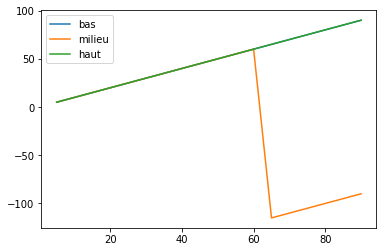

In [37]:
plt.plot(yaw,bas, label='bas')
plt.plot(yaw,milieu, label='milieu')
plt.plot(yaw,haut, label='haut')
plt.legend()